# Analizando el Corpus

En primer lugar vamos a obtener algunas estadísticas sobre el corpus que nos permitan orientar el pre-procesamiento posterior. En concreto, nuestro interés debe centrarse en encontrar:

* Títulos con un número elevado de reviews que puedan provocar bias
* Terminología común a filtrar que no añade valor descriptivo semántico (ej: movie, film, good, bad...)
* Pistas que nos indiquen que modelo de representación podría ser el más adecuado

## Formato del Corpus

El [corpus de Imdb](http://ai.stanford.edu/~amaas/data/sentiment/) consta de un total de 100K de reviews de películas extraídos de la base de datos de IMDB. Este dataset fue inicialmente diseñado para la investigación en Sentiment Analysis. Por este motivo, 50K de los 100K opiniones están etiquetas con la polaridad (en este caso en forma de nota a la película por el usuario), 25K de ellos corresponden a reviews con opiniones positivas y otros 25K a reviews con opiniones negativas. Igualmente, el dataset está balanceado en cuanto a muestras de entrenamiento y test, 25K para training y 25K para test. Los 50k restante no están etiquetados y están pensados para pruebas de unsupervising learning como es nuestro caso.

En primer lugar vamos a ver cual es la distribución de reviews por películas. Nuestro objetivo es ver si el dataset está balanceado en este sentido ya que aquellas películas con gran número de opiniones podrían crear un sesgo y tendríamos que buscar alguna estrategia para balancearlo nosotros mismos.

Cada review viene en un fichero .txt individual cuyo nombre tiene el siguiente formato: **[id]_[rating].txt**. El id es único por review. Para cada grupo de reviews existe un fichero **[urls_[pos, neg, unsup].txt** en el que cada línea contiene el identificador de la película con ID igual al número de línea. Es decir, la línea 0 de este fichero contiene el identificador (URL de IMDB) de la película cuya review pertenece al fichero 0_[rating].txt

In [1]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import os
from collections import Counter
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pprint
from nltk import FreqDist
import gensim
from sklearn.feature_extraction.text import HashingVectorizer
    
vectorizer = HashingVectorizer(stop_words='english', strip_accents='unicode')
analyzer = vectorizer.build_analyzer()

id_pattern = re.compile('title\/(.*)\/')
pp = pprint.PrettyPrinter(width=100, compact=True)

def walk_corpus(path, pattern):
    import fnmatch
    for root, dirnames, filenames in os.walk(path):
        for filename in fnmatch.filter(filenames, pattern):
            yield os.path.join(root, filename)
                
def corpus_stats(path, pattern):
    cnt = Counter()
    for urls_file in walk_corpus(path, pattern):
        with open(urls_file) as f:
            lines = f.readlines()
            for line in lines:
                movie_id = id_pattern.search(line).group(1)
                cnt[movie_id] += 1
            
    distinct = len(cnt)
    size = sum(cnt.values())
    print('Number of different movies reviewed: {}'.format(distinct))
    print('Number of total reviews: {}'.format(size))
    print('Reviews per movie Average: {}'.format(size/distinct))

    df = pd.DataFrame.from_dict(cnt, orient='index').reset_index()
    ax = df.hist(grid=False)
    ax[0][0].set_xlabel("Number of Reviews", labelpad=20, weight='bold', size=12)
    ax[0][0].set_ylabel("Number of Movies", labelpad=20, weight='bold', size=12)

### Distribución de Reviews en el corpus completo



Number of different movies reviewed: 14127
Number of total reviews: 100000
Reviews per movie Average: 7.078643731860976


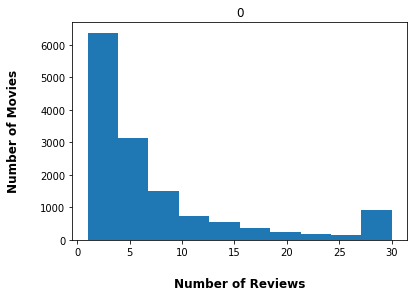

In [2]:
corpus_stats('./resources/aclImdb/', 'urls_*.txt')

### Distribucion de Reviews en datos no etiquetados


Number of different movies reviewed: 7091
Number of total reviews: 50000
Reviews per movie Average: 7.051191651389085


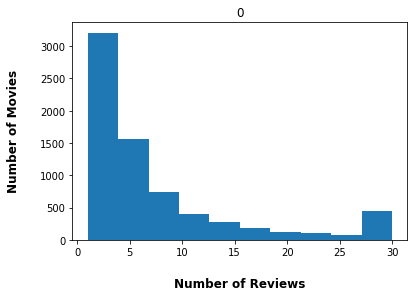

In [3]:
corpus_stats('./resources/aclImdb/train/', 'urls_unsup*')

### Distribucion de Reviews en datos de test

Number of different movies reviewed: 3581
Number of total reviews: 25000
Reviews per movie Average: 6.9812901424183185


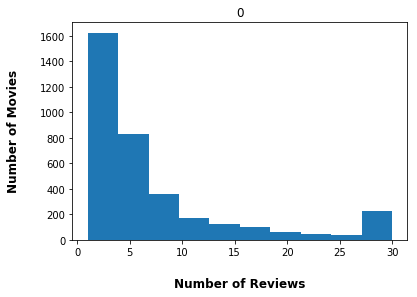

In [4]:
corpus_stats('./resources/aclImdb/test/', 'urls_*.txt')

## Estadísticas de Texto

En este apartado vamos a analizar con ayuda de NLTK como es la distribución del texto a lo largo de todo el corpus. Estaremos interesados en caracteríticas como tokens más frecuentes, longitud del corpus, longitud del vocabulario, etcétera.

In [5]:
def tokenize_corpus(path, pattern, mode='d'):
    for corpus_file in walk_corpus(path, pattern):
        with open(corpus_file, 'r') as next_file:
            next_review = next_file.read()
            tokens = analyzer(next_review)
            if mode == 'd':
                yield tokens
            else:
                for token in tokens:
                    yield token

### Distribución de Frecuencias

La mayoría de herramientas que trabajan con texto en python (NLTK, gensim, Scikit Learn...) necesitan manejar una estructura de datos en la que se implementa una distribución de frecuencias que da lugar a una representación conocida como **Bag of Words (BoW)** en la que simplemente, por cada documento o a nivel global del corpus, se mantiene un contador con el número de apariciones de cada palabra o token

In [6]:
%time dist = FreqDist(tokenize_corpus('./resources/aclImdb/all/', '*.txt', mode='t'))

CPU times: user 30.4 s, sys: 24.5 s, total: 54.9 s
Wall time: 4min 32s


In [7]:
print(dist)
df = pd.DataFrame(dist.most_common(100))
df.columns = ['Token', 'Frecuencia']
df.head(20)

<FreqDist with 140536 samples and 11179231 outcomes>


,Token,Frecuencia
0,br,406911
1,movie,176171
2,film,160801
3,like,80889
4,just,71006
5,good,59495
6,time,50228
7,story,46706
8,really,46282
9,bad,37542


In [8]:
df = pd.DataFrame(dist.most_common()[-100:])
df.columns = ['Token', 'Frecuencia']
df.head(20)

,Token,Frecuencia
0,caisse,1
1,peli,1
2,3462,1
3,strutts,1
4,exhude,1
5,finnlayson,1
6,mmb,1
7,marthesheimer,1
8,trattoria,1
9,mjyoung,1


# Diseñando Nuestro Modelo

## Diccionario

Nuestro modelo de tópicos estará basado en una representación BoW del corpus. Únicamente tendremos en cuenta la frecuencia global de los términos y no una frecuencia de documentos tipo TF-IDF. Lo primero que necesitamos construir es un diccionario con nuestro vocabulario. Empezaremos con un vocabulario sin filtros, para comprobar que resultamos obtenemos y si nuestro estudio previo ha tenido sentido a la hora de ayudarnos con el filtrado posterior.

Empezamos a utilizar gensim para construir el diccionario. 

In [9]:
stream = tokenize_corpus('./resources/aclImdb/all/', '*.txt')
%time dictionary = gensim.corpora.Dictionary(stream)
dictionary.save('original.dict')

CPU times: user 46.2 s, sys: 26.3 s, total: 1min 12s
Wall time: 5min 39s


In [10]:
data = [[dictionary.num_docs, dictionary.num_pos, len(dictionary.token2id)]]
df = pd.DataFrame(data)
df.columns=['Numero de reviews analizadas', 'Numero de tokens analizados', 'Numero de tokens únicos actuales']
df.head()

,Numero de reviews analizadas,Numero de tokens analizados,Numero de tokens únicos actuales
0,100000,11179231,140536


## Corpus

Necesitamos declarar un iterable para acceder en streaming a la representación BoW de cada uno de nuestros documentos (reviews). Este iterable será utilizado de forma eficiente por gensim para entrenar el modelo de forma iterativa en un número determinado de pasadas.

In [11]:
class MovieCorpus(object):

    def __init__(self, path, dictionary):
        self.__path = path
        self.__dictionary = dictionary

    def __iter__(self):
        for tokens in tokenize_corpus(self.__path, '*.txt'):
            yield self.__dictionary.doc2bow(tokens)

    def __len__(self):
        return len(self.__dictionary)

In [12]:
def explore_topic(lda_model, topic_number, topn, output=True):
    """
    accept a ldamodel, atopic number and topn vocabs of interest
    prints a formatted list of the topn terms
    """
    terms = []
    for term, frequency in lda_model.show_topic(topic_number, topn=topn):
        terms += [term]
        if output:
            print(u'{:20} {:.3f}'.format(term, round(frequency, 3)))
    
    return terms

def print_lda_model(lda_model, num_topics=20):
    topic_summaries = []
    print(u'{:20} {}'.format(u'term', u'frequency') + u'\n')
    for i in range(num_topics):
        print('\n')
        print('Topic '+str(i)+' |---------------------\n')
        tmp = explore_topic(lda_model,topic_number=i, topn=10, output=True )
        topic_summaries += [tmp[:5]]
        print

In [13]:
dictionary = gensim.corpora.Dictionary.load('original.dict')
corpus = MovieCorpus("./resources/aclImdb/all", dictionary)
gensim.corpora.MmCorpus.serialize('corpus.mm', corpus)
corpus = gensim.corpora.MmCorpus('corpus.mm')
%time lda_model = gensim.models.ldamodel.LdaModel(corpus, num_topics=20, id2word=dictionary)

CPU times: user 1min 32s, sys: 3.25 s, total: 1min 35s
Wall time: 1min 29s


In [14]:
print_lda_model(lda_model)

term                 frequency



Topic 0 |---------------------

film                 0.007
columbo              0.007
matthau              0.006
br                   0.006
dan                  0.005
felix                0.005
robot                0.004
mildred              0.004
hamlet               0.004
wilder               0.004


Topic 1 |---------------------

br                   0.015
fight                0.007
american             0.006
man                  0.006
chinese              0.005
white                0.005
black                0.005
martial              0.005
old                  0.005
fighting             0.004


Topic 2 |---------------------

game                 0.013
br                   0.013
like                 0.011
sci                  0.008
fi                   0.008
people               0.007
earth                0.007
space                0.007
world                0.007
star                 0.006


Topic 3 |---------------------

br                   0

In [15]:
import pyLDAvis
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary)
vis

/opt/conda/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
12     0.222176 -0.026424       1        1  17.147423
14     0.076917 -0.007994       2        1  16.887070
3      0.128854 -0.074179       3        1  13.853412
6      0.176748 -0.000304       4        1   7.366341
10     0.013081 -0.139703       5        1   6.549838
16     0.003096  0.113639       6        1   4.609186
18    -0.124056 -0.017162       7        1   4.528064
8      0.022304  0.199668       8        1   4.395623
2      0.115074  0.096629       9        1   3.155385
4     -0.145567 -0.097205      10        1   3.042102
17     0.031242 -0.158397      11        1   2.947519
1     -0.055588  0.149620      12        1   2.264216
13     0.018697 -0.017862      13        1   2.127590
19    -0.056217 -0.137647      14        1   2.103425
15    -0.128423 -0.044084      15        1   1.872616
7     -0.006768 -0.003148      16        1   1.726929
11    -0.073224 -0.078164      17        1   1.667551
9     -0.071311  0.194370      18        1   1.405916
0      0.053061  0.014663      19        1   1.188008
5     -0.200097  0.033686      20        1   1.161788, topic_info=      Category           Freq         Term          Total  loglift  logprob
term                                                                       
85     Default  371319.000000           br  371319.000000  30.0000  30.0000
9      Default  151687.000000         film  151687.000000  29.0000  29.0000
19     Default  190205.000000        movie  190205.000000  28.0000  28.0000
863    Default   13606.000000       series   13606.000000  27.0000  27.0000
319    Default    9169.000000          war    9169.000000  26.0000  26.0000
214    Default   26933.000000        films   26933.000000  25.0000  25.0000
466    Default   10851.000000           tv   10851.000000  24.0000  24.0000
145    Default   49905.000000        story   49905.000000  23.0000  23.0000
1396   Default   28656.000000         love   28656.000000  22.0000  22.0000
824    Default   16983.000000        funny   16983.000000  21.0000  21.0000
57     Default   82077.000000         like   82077.000000  20.0000  20.0000
890    Default    7139.000000         book    7139.000000  19.0000  19.0000
1822   Default    6239.000000      episode    6239.000000  18.0000  18.0000
1601   Default   12392.000000        music   12392.000000  17.0000  17.0000
342    Default   45267.000000        great   45267.000000  16.0000  16.0000
12     Default   68363.000000         good   68363.000000  15.0000  15.0000
328    Default   30917.000000          bad   30917.000000  14.0000  14.0000
577    Default   16600.000000       action   16600.000000  13.0000  13.0000
123    Default   27774.000000         life   27774.000000  12.0000  12.0000
53     Default   69024.000000         just   69024.000000  11.0000  11.0000
2213   Default   12619.000000       family   12619.000000  10.0000  10.0000
839    Default   14110.000000       horror   14110.000000   9.0000   9.0000
583    Default   28821.000000         best   28821.000000   8.0000   8.0000
404    Default   34254.000000       movies   34254.000000   7.0000   7.0000
805    Default   13241.000000       comedy   13241.000000   6.0000   6.0000
446    Default   24478.000000          man   24478.000000   5.0000   5.0000
351    Default   38144.000000       people   38144.000000   4.0000   4.0000
32     Default   10029.000000        shows   10029.000000   3.0000   3.0000
3668   Default    5783.000000         game    5783.000000   2.0000   2.0000
416    Default   12810.000000         role   12810.000000   1.0000   1.0000
...        ...            ...          ...            ...      ...      ...
10758  Topic20     150.884323       reagan     151.776276   4.4493  -6.7578
11261  Topic20    1059.859131       welles    1072.547974   4.4433  -4.8084
24838  Topic20     336.252136       bacall     338.926605   4.4473  -5.9565
5877   Topic20     221.127655    

## Evaluando Modelo LDA

Necesitamos poder comparar los distintos modelos que vamos a ir generando para poder comprobar que van mejorando con las acciones que tomamos. Existen muchas diversas formas de evaluar un modelo LDA, cualquiera compatible con evaluar clusters procedentes de algoritmos de clustering.

Los clusters se suelen evaluar midiendo la coherencia de sus componentes. En nuestro caso concreto, cada tópico tendrá mayor calidad si:

* Los documentos dominados por los mismos tópicos han de ser similares entre si
* Los documentos dominados por tópicos diferentes y poco solapados han de ser distintos entre si

Afortunadamente gensim proporciona sus propias herramientas para medir la coherencia que usamos a continuación.

In [16]:
from gensim.models.coherencemodel import CoherenceModel
cm = CoherenceModel(model=lda_model, corpus=corpus, coherence='u_mass')
cm.get_coherence_per_topic()

[-10.032941419962542,
 -3.9864246115962896,
 -2.4919593778714675,
 -1.311982072303147,
 -2.5857165896806493,
 -7.3642074519920957,
 -1.4287131532667272,
 -2.3121137382222434,
 -2.1619498560928552,
 -3.8034343307433227,
 -2.2371277889597936,
 -5.8337433930510461,
 -1.3073984738255287,
 -1.7636372734716306,
 -1.425172461377227,
 -2.9807861965716711,
 -2.4225509567624224,
 -2.0712303292675527,
 -1.8353441343163002,
 -2.3121051579877721]

## Filtrando Tokens Frecuentes

In [17]:
mc100 = [mc[0] for mc in dist.most_common(100)]
terms_id = lda_model.get_topic_terms(2)
terms_str = [dictionary.id2token[id[0]] for id in terms_id if id[0] in dictionary.id2token]
list(set(mc100) & set(terms_str))

['br', 'like', 'world', 'people']

In [18]:
def dictionary_filter_most_frequent(dictionary, dist, n=200):
    most_common = dist.most_common(n)
    mc_ids = [dictionary.token2id[t[0]] for t in most_common]
    dictionary.filter_tokens(bad_ids=mc_ids)
    dictionary.compactify()

In [19]:
print('Longitud del vocabulario actual: {}'.format(len(dictionary.token2id)))
dictionary_filter_most_frequent(dictionary, dist)
# Filter out words that occur less than 10 documents, or more than 50% of the documents.
dictionary.filter_extremes(no_below=10, no_above=0.5)
print('Longitud del vocabulario Filtrado: {}'.format(len(dictionary.token2id)))

Longitud del vocabulario actual: 140536
Longitud del vocabulario Filtrado: 35598


## Normalizando Tokens

Además del lowercase, vamos a eliminar también los plurales

In [20]:
def normalize_dictionary(dictionary):
    from textblob import Word
    plurals = []
    for token in dictionary.values():
        if token.endswith('s'):
            singular = Word(token).singularize()
            if token != singular:
                singular_id = dictionary.token2id.get(singular, None)
                if singular_id:
                    plurals.append(dictionary.token2id[token])
                    
    dictionary.filter_tokens(bad_ids=plurals)
    dictionary.compactify()
    return plurals

In [21]:
print('Numero de tokens únicos actuales: {}'.format(len(dictionary.token2id)))
plurals = normalize_dictionary(dictionary)
print('Numero de plurales detectados: {}'.format(len(plurals)))
print('Numero de tokens únicos actuales: {}'.format(len(dictionary.token2id)))

Numero de tokens únicos actuales: 35598
Numero de plurales detectados: 5173
Numero de tokens únicos actuales: 30425


In [22]:
dictionary.save('normalized.dict')

In [23]:
dictionary = gensim.corpora.Dictionary.load('normalized.dict')
corpus = MovieCorpus("./resources/aclImdb/all", dictionary)
gensim.corpora.MmCorpus.serialize('corpus1.mm', corpus)
corpus = gensim.corpora.MmCorpus('corpus1.mm')
%time lda_model = gensim.models.ldamodel.LdaModel(corpus, num_topics=20, id2word=dictionary)

CPU times: user 1min 3s, sys: 30 ms, total: 1min 3s
Wall time: 1min 2s


In [24]:
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary)
vis

/opt/conda/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
9     -0.131307 -0.069514       1        1  13.103644
7     -0.061934  0.151228       2        1   8.869587
2     -0.170297 -0.120235       3        1   8.087161
14    -0.045017 -0.088699       4        1   7.564739
12    -0.063248  0.147751       5        1   7.245821
18     0.178753 -0.000717       6        1   5.834367
0     -0.050563  0.157609       7        1   5.801692
11     0.078709  0.085644       8        1   5.117826
6     -0.177413 -0.043310       9        1   4.759460
1      0.029825  0.005403      10        1   4.245595
10    -0.185359 -0.006411      11        1   3.884592
19     0.101339 -0.074024      12        1   3.812302
15     0.031584 -0.182804      13        1   3.495428
3      0.124389  0.105731      14        1   3.437963
5      0.058344 -0.050509      15        1   3.376087
8      0.088939 -0.178094      16        1   2.561762
13    -0.018647  0.107634      17        1   2.519143
16     0.100922  0.041275      18        1   2.356151
4      0.130102 -0.037398      19        1   2.152581
17    -0.019119  0.049439      20        1   1.774098, topic_info=      Category         Freq         Term        Total  loglift  logprob
term                                                                   
1361   Default  6809.000000      episode  6809.000000  30.0000  30.0000
425    Default  5181.000000       killer  5181.000000  29.0000  29.0000
4337   Default  3970.000000  documentary  3970.000000  28.0000  28.0000
3097   Default  3084.000000    animation  3084.000000  27.0000  27.0000
352    Default  4593.000000        fight  4593.000000  26.0000  26.0000
2684   Default  3254.000000       season  3254.000000  25.0000  25.0000
3216   Default  3569.000000      musical  3569.000000  24.0000  24.0000
4832   Default  4631.000000       murder  4631.000000  23.0000  23.0000
514    Default  3856.000000           fi  3856.000000  22.0000  22.0000
526    Default  3847.000000          sci  3847.000000  21.0000  21.0000
1228   Default  6718.000000        loved  6718.000000  20.0000  20.0000
655    Default  5414.000000     children  5414.000000  19.0000  19.0000
2850   Default  5385.000000         game  5385.000000  18.0000  18.0000
1040   Default  3759.000000         song  3759.000000  17.0000  17.0000
2240   Default  2515.000000       disney  2515.000000  16.0000  16.0000
902    Default  7538.000000    wonderful  7538.000000  15.0000  15.0000
4888   Default  2620.000000        dance  2620.000000  14.0000  14.0000
3997   Default  4484.000000     thriller  4484.000000  13.0000  13.0000
1282   Default  2427.000000        match  2427.000000  12.0000  12.0000
222    Default  6971.000000     remember  6971.000000  11.0000  11.0000
1002   Default  6271.000000       mother  6271.000000  10.0000  10.0000
597    Default  5099.000000         town  5099.000000   9.0000   9.0000
27     Default  3267.000000       french  3267.000000   8.0000   8.0000
1320   Default  4229.000000       police  4229.000000   7.0000   7.0000
462    Default  2501.000000      western  2501.000000   6.0000   6.0000
152    Default  5643.000000      history  5643.000000   5.0000   5.0000
787    Default  4872.000000        blood  4872.000000   4.0000   4.0000
829    Default  5317.000000      michael  5317.000000   3.0000   3.0000
5032   Default  2083.000000          jim  2083.000000   2.0000   2.0000
779    Default  2055.000000     animated  2055.000000   1.0000   1.0000
...        ...          ...          ...          ...      ...      ...
14139  Topic20   162.768860           je   163.676605   4.0263  -6.5615
12726  Topic20   167.632965      stepped   168.584152   4.0262  -6.5320
25107  Topic20   164.829010     mcintire   165.771713   4.0262  -6.5489
6363   Topic20   159.689804  entertainer   160.611252   4.0261  -6.5806
1068   Topic20  1084.169067        lynch  1098.419067   4.0188  -4.6652
7368   Topic20   348.819763   fas

In [25]:
cm = CoherenceModel(model=lda_model, corpus=corpus, coherence='u_mass')
cm.get_coherence_per_topic()

[-3.9534404818014028,
 -3.5931871061348555,
 -2.8469590246295327,
 -3.9635307302189164,
 -7.0074178816246961,
 -5.7931401776414795,
 -2.8886477018424355,
 -2.6723564647243521,
 -4.9131708660924627,
 -2.7688229218324523,
 -2.8831198775742366,
 -3.1569037810755018,
 -3.0601582840816399,
 -5.2281064358990408,
 -2.7551154861525831,
 -3.9736584930371128,
 -8.0547564191288537,
 -8.6929493192273384,
 -3.1382554046725688,
 -3.2005540453815793]

## Limitando el Vocabulario por Frecuencia

In [26]:
def dictionary_keep_n_frequent(dictionary, dist, n=5000):
    tokens_by_freq = dist.most_common(len(dist))
    mf = []
    for t in tokens_by_freq:
        id = dictionary.token2id.get(t[0], None)
        if id:
            mf.append(id)
            if len(mf) == n:
                break
    dictionary.filter_tokens(good_ids=mf)

#### 10 Topics

In [28]:
dictionary = gensim.corpora.Dictionary.load('normalized.dict')
dictionary_keep_n_frequent(dictionary, dist)
corpus = MovieCorpus("./resources/aclImdb/all", dictionary)
gensim.corpora.MmCorpus.serialize('corpus3.mm', corpus)
corpus = gensim.corpora.MmCorpus('corpus3.mm')
%time lda_model= gensim.models.ldamodel.LdaModel(corpus, num_topics=10, id2word=dictionary)
print_lda_model(lda_model, 10)

CPU times: user 52.5 s, sys: 0 ns, total: 52.5 s
Wall time: 52.6 s
term                 frequency



Topic 0 |---------------------

episode              0.011
loved                0.009
remember             0.008
liked                0.007
animation            0.006
came                 0.006
enjoyed              0.006
favorite             0.005
recommend            0.005
season               0.005


Topic 1 |---------------------

human                0.004
cinema               0.003
viewer               0.003
art                  0.003
truly                0.003
drama                0.003
documentary          0.003
lives                0.003
heart                0.003
experience           0.003


Topic 2 |---------------------

wonderful            0.006
musical              0.006
stars                0.005
supporting           0.005
michael              0.005
roles                0.005
mr                   0.004
jane                 0.004
paul                 0.004
perfect         

#### 20 Topics

In [29]:
%time lda_model = gensim.models.ldamodel.LdaModel(corpus, num_topics=20, id2word=dictionary)
print_lda_model(lda_model, 20)

CPU times: user 54.7 s, sys: 0 ns, total: 54.7 s
Wall time: 54.8 s
term                 frequency



Topic 0 |---------------------

french               0.006
lives                0.006
son                  0.006
mother               0.005
society              0.005
human                0.005
child                0.005
children             0.004
powerful             0.004
shown                0.004


Topic 1 |---------------------

animation            0.013
disney               0.011
animated             0.008
recommend            0.007
cartoon              0.007
voice                0.007
fantastic            0.007
amazing              0.007
wonderful            0.007
children             0.006


Topic 2 |---------------------

police               0.012
murder               0.010
town                 0.009
crime                0.008
finds                0.007
car                  0.007
brother              0.006
friend               0.006
stewart              0.006
detective       

In [30]:
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary)
vis

/opt/conda/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
12    -0.033826  0.201758       1        1  10.319037
4      0.107040  0.036179       2        1   8.235392
0      0.150490 -0.027474       3        1   7.790033
5     -0.023333  0.087812       4        1   7.571996
16     0.180146 -0.002543       5        1   6.893084
2     -0.036668 -0.148727       6        1   6.762604
19    -0.047595  0.189828       7        1   5.874511
15     0.029192 -0.105959       8        1   5.461340
8     -0.135180  0.035571       9        1   4.906588
18     0.051074 -0.091396      10        1   4.746106
1      0.084493  0.147098      11        1   4.461963
11     0.180305 -0.009940      12        1   4.296834
13     0.066757 -0.138990      13        1   3.752858
14     0.053147  0.018218      14        1   3.503274
3     -0.136155 -0.011155      15        1   3.377431
7     -0.144340 -0.113107      16        1   3.134639
10    -0.111509 -0.103282      17        1   2.724461
9     -0.058627  0.031174      18        1   2.277170
17    -0.004987 -0.019791      19        1   2.022840
6     -0.170424  0.024727      20        1   1.887838, topic_info=     Category         Freq        Term        Total  loglift  logprob
term                                                                 
1992  Default  5602.000000        game  5602.000000  30.0000  30.0000
1479  Default  4311.000000        jack  4311.000000  29.0000  29.0000
282   Default  4437.000000       fight  4437.000000  28.0000  28.0000
793   Default  3613.000000        song  3613.000000  27.0000  27.0000
329   Default  5446.000000      killer  5446.000000  26.0000  26.0000
389   Default  2835.000000          fi  2835.000000  25.0000  25.0000
399   Default  2829.000000         sci  2829.000000  24.0000  24.0000
546   Default  2957.000000       space  2957.000000  23.0000  23.0000
998   Default  4279.000000      police  4279.000000  22.0000  22.0000
612   Default  4489.000000       blood  4489.000000  21.0000  21.0000
2701  Default  2696.000000    japanese  2696.000000  20.0000  20.0000
2200  Default  3446.000000     musical  3446.000000  19.0000  19.0000
1411  Default  4559.000000    violence  4559.000000  18.0000  18.0000
629   Default  3368.000000        gore  3368.000000  17.0000  17.0000
637   Default  3662.000000        king  3662.000000  16.0000  16.0000
1666  Default  3598.000000       earth  3598.000000  15.0000  15.0000
1027  Default  6629.000000     episode  6629.000000  14.0000  14.0000
977   Default  2713.000000       match  2713.000000  13.0000  13.0000
2140  Default  3003.000000   animation  3003.000000  12.0000  12.0000
628   Default  5293.000000       girls  5293.000000  11.0000  11.0000
938   Default  6577.000000       loved  6577.000000  10.0000  10.0000
354   Default  2587.000000     western  2587.000000   9.0000   9.0000
188   Default  4884.000000       waste  4884.000000   8.0000   8.0000
689   Default  7224.000000   wonderful  7224.000000   7.0000   7.0000
574   Default  6530.000000    terrible  6530.000000   6.0000   6.0000
2999  Default  4623.000000      murder  4623.000000   5.0000   5.0000
1298  Default  2800.000000         lee  2800.000000   4.0000   4.0000
1062  Default  2156.000000     science  2156.000000   3.0000   3.0000
1607  Default  2449.000000      disney  2449.000000   2.0000   2.0000
120   Default  5631.000000     history  5631.000000   1.0000   1.0000
...       ...          ...         ...          ...      ...      ...
4537  Topic20   175.340897      salman   176.287689   3.9644  -6.3061
2389  Topic20   235.767578       lance   237.132645   3.9640  -6.0100
3475  Topic20   472.636719        pulp   475.650116   3.9634  -5.3145
4859  Topic20   350.575043         ace   353.453003   3.9616  -5.6133
2739  Topic20   109.044533      barney   110.033012   3.9607  -6.7811
3493  Topic20   248.061371     foolish   251.626450   3.9555  -5.9592
2542  Topic20   518.828979     warming 

In [31]:
cm = CoherenceModel(model=lda_model, corpus=corpus, coherence='u_mass')
cm.get_coherence_per_topic()

[-2.8561275425672705,
 -2.833052465368739,
 -3.0008402280223101,
 -3.2782626918643532,
 -3.1920727887574207,
 -2.6555455529743686,
 -5.7601801676443065,
 -4.0931436036412698,
 -3.1504458628515741,
 -4.3777622050644203,
 -4.0517723192450434,
 -3.5856611014146318,
 -2.6940125063354703,
 -4.1046104677807627,
 -3.3849551574906709,
 -3.1200511229667249,
 -2.8627028836307149,
 -4.2825140334526459,
 -3.4882195331548256,
 -2.8879114310037339]

#### 50 topics

In [32]:
%time lda_model= gensim.models.ldamodel.LdaModel(corpus, num_topics=50, id2word=dictionary)
print_lda_model(lda_model, 50)

CPU times: user 1min 28s, sys: 1min 5s, total: 2min 34s
Wall time: 1min 8s
term                 frequency



Topic 0 |---------------------

song                 0.039
animation            0.035
dance                0.027
disney               0.026
voice                0.025
musical              0.025
animated             0.023
dancing              0.019
cartoon              0.019
singing              0.018


Topic 1 |---------------------

white                0.036
jean                 0.017
delightful           0.016
ford                 0.015
class                0.012
heaven               0.012
comic                0.011
la                   0.011
sir                  0.010
clark                0.009


Topic 2 |---------------------

mother               0.057
daughter             0.036
sister               0.019
queen                0.018
tale                 0.016
husband              0.013
son                  0.011
lady                 0.011
fairy                0.009
helen   

In [33]:
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary)
vis

/opt/conda/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
12     0.242973  0.015605       1        1  5.708097
26     0.039043 -0.186032       2        1  5.545400
46    -0.003703 -0.171125       3        1  5.112604
20     0.071319  0.005229       4        1  4.618308
28     0.232277  0.078046       5        1  3.780187
38     0.040216 -0.083498       6        1  3.777303
3      0.063464 -0.169431       7        1  3.682285
31    -0.043167 -0.161488       8        1  3.677654
40     0.168971  0.030144       9        1  3.174341
30    -0.065554  0.072845      10        1  3.083995
5      0.201174 -0.024939      11        1  2.881871
6     -0.150083 -0.053314      12        1  2.649862
44     0.082435 -0.167630      13        1  2.613054
49     0.139371  0.002296      14        1  2.485264
32     0.045766  0.079164      15        1  2.476303
29     0.001134  0.038555      16        1  2.224480
47    -0.078758  0.057737      17        1  2.199287
23     0.180459  0.015571      18        1  2.189032
37    -0.076341 -0.086677      19        1  2.141892
27    -0.026857  0.007447      20        1  1.950741
41     0.048715  0.001009      21        1  1.862996
15     0.153318  0.107011      22        1  1.855720
0      0.016385  0.004744      23        1  1.675220
2     -0.054761 -0.098228      24        1  1.607871
1     -0.040540 -0.116945      25        1  1.566743
14    -0.130011  0.033894      26        1  1.543157
22    -0.136164 -0.052043      27        1  1.390381
42    -0.048284 -0.046435      28        1  1.317955
25     0.014063  0.068772      29        1  1.311256
19     0.017457  0.119719      30        1  1.275580
35    -0.115278 -0.064724      31        1  1.228010
36     0.089607  0.027497      32        1  1.193343
7     -0.072671 -0.070796      33        1  1.191874
17    -0.047667  0.014553      34        1  1.055552
10    -0.030825 -0.052439      35        1  1.025792
13    -0.036148 -0.022021      36        1  1.002199
43     0.047256  0.001635      37        1  0.991474
4     -0.139612  0.022951      38        1  0.978538
33    -0.036410  0.067166      39        1  0.972515
34    -0.008460  0.048322      40        1  0.959920
18    -0.072782  0.064091      41        1  0.863945
39    -0.046933  0.062098      42        1  0.851930
21    -0.101211  0.106084      43        1  0.845287
16     0.051626  0.011954      44        1  0.841034
45    -0.026974  0.073668      45        1  0.839265
48    -0.110532  0.043187      46        1  0.823173
8     -0.097403  0.186267      47        1  0.819815
11    -0.050249  0.061485      48        1  0.761750
24    -0.032348  0.006912      49        1  0.696270
9     -0.067302  0.092105      50        1  0.679473, topic_info=     Category         Freq           Term        Total  loglift  logprob
term                                                                    
1027  Default  6348.000000        episode  6348.000000  30.0000  30.0000
1992  Default  6493.000000           game  6493.000000  29.0000  29.0000
511   Default  5962.000000       children  5962.000000  28.0000  28.0000
765   Default  6404.000000         mother  6404.000000  27.0000  27.0000
175   Default  6033.000000             mr  6033.000000  26.0000  26.0000
2777  Default  4143.000000    documentary  4143.000000  25.0000  25.0000
640   Default  5537.000000        michael  5537.000000  24.0000  24.0000
510   Default  5193.000000          child  5193.000000  23.0000  23.0000
329   Default  4768.000000         killer  4768.000000  22.0000  22.0000
460   Default  5673.000000           town  5673.000000  21.0000  21.0000
1846  Default  3469.000000      fantastic  3469.000000  20.0000  20.0000
637   Default  3824.000000           king  3824.000000  19.0000  19.0000
35    Default  7428.000000          video  7428.000000  18.0000  18.0000
484   Default  3333.000000          novel  3333.000000  17.0000  17.0000
257   Default  2884.000000       

In [34]:
cm = CoherenceModel(model=lda_model, corpus=corpus, coherence='u_mass')
cm.get_coherence_per_topic()

[-3.4614971837559625,
 -4.7771585373116059,
 -4.3253281824032843,
 -2.9839482702073035,
 -4.8489708922601382,
 -3.6398039982931705,
 -3.2704933869629138,
 -4.4320117639321195,
 -6.1896508643518535,
 -6.6909727607371963,
 -6.7928128260535132,
 -5.8811387474049992,
 -2.8649428320489707,
 -4.7210190404151389,
 -4.3212931297764268,
 -5.227872819014717,
 -7.3120737027684291,
 -6.5452579776343676,
 -5.1446913776117658,
 -4.9881192513877819,
 -2.8505356981424996,
 -5.324449450978479,
 -3.7317718238884852,
 -3.329331925851835,
 -6.6594817169917526,
 -5.4354737539054154,
 -2.7931415351651068,
 -3.8789489134610915,
 -2.8238792891269644,
 -3.0935098343984131,
 -3.2515165369951426,
 -3.6893631625516696,
 -3.773642458106524,
 -6.1115490379334565,
 -6.6960642894009004,
 -6.8346655446795443,
 -6.0068477688933646,
 -3.169054912997689,
 -2.9293166765843135,
 -6.2501216293068174,
 -2.8946187422255902,
 -3.4541973882098307,
 -4.0670899912787997,
 -6.1737786392291296,
 -3.6088299990950214,
 -6.75199384956

## Limite de Reviews por Película

Un primer filtro que podemos aplicar para evitar bias es un límite sobre el número de revies para una misma película. Usaremos un parámetro configurable con un valor inicial de 10 después de estudiar la primera gráfica

In [35]:
ids_by_path = {}
for urls_file in walk_corpus('./resources/aclImdb/all/', 'urls.urls'):
    dirname = os.path.dirname(urls_file)
    with open(urls_file) as f:
            ids_map = {}
            lines = f.readlines()
            for index, line in enumerate(lines):
                movie_id = id_pattern.search(line).group(1)
                ids_map[index] = movie_id
            ids_by_path[dirname] = ids_map
            
line_id_pattern = re.compile('([0-9]+)_[0-9]+')

In [36]:
def tokenize_corpus(path, pattern, min_df=1, mode='d', limit=10):
    movie_counter = Counter()

    for corpus_file in walk_corpus(path, pattern):
        dirname = os.path.dirname(corpus_file)
        line_id = int(line_id_pattern.search(corpus_file).group(1))
        ids_map = ids_by_path[dirname]
        movie_id = ids_map[line_id]
        if movie_counter[movie_id] <= limit:
            movie_counter[movie_id] += 1
            with open(corpus_file, 'r') as next_file:
                next_review = next_file.read()
                tokens = analyzer(next_review)
                if mode == 'd':
                    yield tokens
                else:
                    for token in tokens:
                        yield token

In [37]:
%time dist_limited = FreqDist(tokenize_corpus('./resources/aclImdb/all/', '*.txt', mode='t'))
print(dist_limited)
pp.pprint(dist_limited.most_common(100))

CPU times: user 34.2 s, sys: 24.8 s, total: 59 s
Wall time: 39min 10s
<FreqDist with 123728 samples and 7949267 outcomes>
[('br', 288630), ('movie', 122232), ('film', 112554), ('like', 58209), ('just', 51314),
 ('good', 41899), ('time', 35474), ('really', 32889), ('story', 32581), ('bad', 28692),
 ('people', 25751), ('don', 25288), ('great', 23732), ('make', 23451), ('way', 22204),
 ('movies', 21570), ('characters', 20484), ('character', 19761), ('films', 19659), ('think', 19640),
 ('watch', 19592), ('plot', 19382), ('acting', 18633), ('seen', 18399), ('little', 18011),
 ('did', 17771), ('know', 17664), ('life', 17515), ('love', 17289), ('better', 16980),
 ('best', 16617), ('does', 16488), ('man', 16318), ('end', 15917), ('scene', 15616),
 ('scenes', 15126), ('say', 14884), ('ve', 14401), ('real', 13451), ('thing', 13275),
 ('watching', 13227), ('doesn', 13076), ('didn', 12945), ('director', 12929), ('actors', 12838),
 ('old', 12596), ('funny', 12504), ('actually', 12413), ('years', 12

In [38]:
%time dictionary = gensim.corpora.Dictionary(tokenize_corpus('./resources/aclImdb/all/', '*.txt'))
data = [[dictionary.num_docs, dictionary.num_pos, len(dictionary.token2id)]]
df = pd.DataFrame(data)
df.columns=['Numero de reviews analizadas', 'Numero de tokens analizados', 'Numero de tokens únicos actuales']
df.head()

CPU times: user 2min 8s, sys: 1min 32s, total: 3min 40s
Wall time: 26min 30s


,Numero de reviews analizadas,Numero de tokens analizados,Numero de tokens únicos actuales
0,72310,7949267,123728


In [39]:
dictionary.save('limited.dict')

### Aplicando normalización y filtrado de vocabulario

In [40]:
dictionary_filter_most_frequent(dictionary, dist_limited)
dictionary.filter_extremes(no_below=10, no_above=0.5)
plurals = normalize_dictionary(dictionary)
dictionary.save('limited.normalized.dict')
corpus = MovieCorpus("./resources/aclImdb/all", dictionary)
gensim.corpora.MmCorpus.serialize('corpus4.mm', corpus)
corpus = gensim.corpora.MmCorpus('corpus4.mm')
%time lda_model = gensim.models.ldamodel.LdaModel(corpus, num_topics=20, id2word=dictionary)
print_lda_model(lda_model)

CPU times: user 45.3 s, sys: 0 ns, total: 45.3 s
Wall time: 45.4 s
term                 frequency



Topic 0 |---------------------

columbo              0.006
documentary          0.005
chinese              0.003
japanese             0.003
sword                0.003
science              0.003
italian              0.003
island               0.003
fiction              0.003
japan                0.003


Topic 1 |---------------------

laugh                0.005
enjoy                0.005
definitely           0.005
recommend            0.005
couldn               0.004
sound                0.004
liked                0.003
enjoyed              0.003
hope                 0.003
waste                0.003


Topic 2 |---------------------

mary                 0.006
richard              0.005
garbo                0.005
wonderful            0.005
silent               0.005
career               0.004
anna                 0.004
actress              0.004
peter                0.004
french          

In [41]:
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary)
vis

/opt/conda/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.127800 -0.095539       1        1  14.062597
15     0.047565  0.172101       2        1   7.633091
13     0.097521 -0.138886       3        1   6.924178
11     0.068641  0.024620       4        1   6.275726
10    -0.077290 -0.011902       5        1   6.246656
6      0.115740 -0.019079       6        1   6.088231
9      0.055376  0.097807       7        1   5.857435
7      0.021979 -0.153274       8        1   5.015833
4      0.067610  0.098417       9        1   4.733958
12     0.090602 -0.026713      10        1   4.668221
0      0.067654  0.105333      11        1   4.506664
2     -0.134857  0.085392      12        1   4.407173
19     0.045060  0.148586      13        1   4.377197
17     0.055815  0.002201      14        1   3.496386
8     -0.190528  0.063823      15        1   3.320606
18    -0.170274  0.011611      16        1   3.095681
16    -0.081364 -0.089413      17        1   2.840758
14     0.019125 -0.129625      18        1   2.508556
3     -0.142053 -0.096009      19        1   2.011446
5     -0.084123 -0.049451      20        1   1.929604, topic_info=      Category         Freq         Term        Total  loglift  logprob
term                                                                   
2824   Default  6556.000000         game  6556.000000  30.0000  30.0000
555    Default  4222.000000     episodes  4222.000000  29.0000  29.0000
2660   Default  2591.000000       season  2591.000000  28.0000  28.0000
423    Default  3237.000000       killer  3237.000000  27.0000  27.0000
7263   Default  1728.000000         bond  1728.000000  26.0000  26.0000
3068   Default  2281.000000    animation  2281.000000  25.0000  25.0000
3743   Default  1949.000000      cartoon  1949.000000  24.0000  24.0000
595    Default  4351.000000         town  4351.000000  23.0000  23.0000
1275   Default  1713.000000        match  1713.000000  22.0000  22.0000
511    Default  1824.000000           fi  1824.000000  21.0000  21.0000
524    Default  1774.000000          sci  1774.000000  20.0000  20.0000
825    Default  3336.000000      michael  3336.000000  19.0000  19.0000
808    Default  1930.000000         gore  1930.000000  18.0000  18.0000
782    Default  3279.000000        blood  3279.000000  17.0000  17.0000
695    Default  2260.000000        space  2260.000000  16.0000  16.0000
4132   Default  2773.000000     japanese  2773.000000  15.0000  15.0000
2222   Default  1624.000000       disney  1624.000000  14.0000  14.0000
4288   Default  3308.000000  documentary  3308.000000  13.0000  13.0000
720    Default  1764.000000       nudity  1764.000000  12.0000  12.0000
807    Default  3622.000000        girls  3622.000000  11.0000  11.0000
1570   Default  2798.000000        james  2798.000000  10.0000  10.0000
3038   Default  1170.000000    christmas  1170.000000   9.0000   9.0000
1101   Default  3338.000000        david  3338.000000   8.0000   8.0000
1031   Default  3299.000000         song  3299.000000   7.0000   7.0000
1921   Default  3031.000000     violence  3031.000000   6.0000   6.0000
514    Default  2014.000000          gay  2014.000000   5.0000   5.0000
684    Default  2997.000000      husband  2997.000000   4.0000   4.0000
1556   Default  1965.000000           dr  1965.000000   3.0000   3.0000
1362   Default  3901.000000        human  3901.000000   2.0000   2.0000
1464   Default  2036.000000          dog  2036.000000   1.0000   1.0000
...        ...          ...          ...          ...      ...      ...
10783  Topic20   116.484657    delirious   117.419342   3.9399  -6.6306
13048  Topic20   118.761002       regain   119.725327   3.9398  -6.6113
4055   Topic20   382.767151    streisand   387.480682   3.9356  -5.4409
15152  Topic20   348.938385      olivier   357.767822   3.9229  -5.5335
11     Topic20   213.214584      orleans   216.936630   3.9305  -6.0261
5378   Topic20   170.284348      

In [42]:
cm = CoherenceModel(model=lda_model, corpus=corpus, coherence='u_mass')
cm.get_coherence_per_topic()

[-4.3616609091182115,
 -2.7465673949501515,
 -3.4811417984134869,
 -5.9280361289722503,
 -4.0161831839381934,
 -7.9482366898940526,
 -2.9912021389039625,
 -3.052622723206293,
 -3.8030184094289372,
 -3.0023615648154167,
 -2.9690230695740603,
 -2.9570892857805959,
 -2.7591400898016882,
 -2.8259379334456156,
 -8.0770559845894887,
 -2.8800181701494303,
 -5.3475734230093446,
 -7.6710752237359596,
 -3.7518870578909662,
 -4.7549423292440078]

In [43]:
dictionary_keep_n_frequent(dictionary, dist_limited)
corpus = MovieCorpus("./resources/aclImdb/all", dictionary)
gensim.corpora.MmCorpus.serialize('corpus5.mm', corpus)
corpus = gensim.corpora.MmCorpus('corpus5.mm')
%time lda_model = gensim.models.ldamodel.LdaModel(corpus, num_topics=20, id2word=dictionary)
lda_model.save('limited.normalized.filtered.model')
print_lda_model(lda_model)

CPU times: user 43.9 s, sys: 0 ns, total: 43.9 s
Wall time: 44.1 s
term                 frequency



Topic 0 |---------------------

car                  0.023
town                 0.013
ed                   0.012
michael              0.011
wood                 0.010
harris               0.009
jackson              0.008
superman             0.007
joan                 0.007
ice                  0.007


Topic 1 |---------------------

british              0.010
arthur               0.006
london               0.004
hardy                0.004
adventure            0.004
sequence             0.004
mission              0.004
water                0.003
west                 0.003
number               0.003


Topic 2 |---------------------

fight                0.021
japanese             0.014
gay                  0.014
fighting             0.011
guys                 0.010
hero                 0.009
fu                   0.009
lee                  0.009
western              0.009
chinese         

In [44]:
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary)
vis

/opt/conda/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
14     0.000512 -0.135539       1        1  11.412906
10     0.094236  0.013734       2        1   8.567513
6     -0.093480  0.070186       3        1   7.022754
16     0.159897  0.036442       4        1   6.960013
15    -0.074496 -0.126566       5        1   6.723136
19     0.135840 -0.019905       6        1   6.469729
7      0.215148  0.035638       7        1   6.075935
3      0.061083 -0.027382       8        1   5.827634
1     -0.116788 -0.043873       9        1   4.940029
17    -0.122233  0.143431      10        1   4.614120
8     -0.014559 -0.164259      11        1   4.307085
12    -0.090206  0.062018      12        1   3.934847
2     -0.025817  0.047105      13        1   3.491457
18     0.072952 -0.032511      14        1   3.322243
11    -0.012500  0.109840      15        1   3.040558
9     -0.128456 -0.062004      16        1   2.921050
13    -0.008925 -0.153316      17        1   2.894525
5      0.096936  0.031487      18        1   2.579846
4     -0.150013  0.034537      19        1   2.461638
0      0.000868  0.180938      20        1   2.432978, topic_info=     Category         Freq         Term        Total  loglift  logprob
term                                                                  
1993  Default  6963.000000         game  6963.000000  30.0000  30.0000
1455  Default  3229.000000          car  3229.000000  29.0000  29.0000
514   Default  3752.000000     children  3752.000000  28.0000  28.0000
281   Default  3633.000000        fight  3633.000000  27.0000  27.0000
795   Default  3027.000000         song  3027.000000  26.0000  26.0000
428   Default  4060.000000     episodes  4060.000000  25.0000  25.0000
2777  Default  3111.000000  documentary  3111.000000  24.0000  24.0000
176   Default  3676.000000           mr  3676.000000  23.0000  23.0000
462   Default  4515.000000         town  4515.000000  22.0000  22.0000
2141  Default  2838.000000    animation  2838.000000  21.0000  21.0000
2699  Default  2378.000000     japanese  2378.000000  20.0000  20.0000
2198  Default  2277.000000      musical  2277.000000  19.0000  19.0000
179   Default  6015.000000     remember  6015.000000  18.0000  18.0000
2501  Default  2568.000000      cartoon  2568.000000  17.0000  17.0000
766   Default  1809.000000       german  1809.000000  16.0000  16.0000
1886  Default  2363.000000       season  2363.000000  15.0000  15.0000
899   Default  4351.000000        laugh  4351.000000  14.0000  14.0000
550   Default  2349.000000        space  2349.000000  13.0000  13.0000
329   Default  3688.000000       killer  3688.000000  12.0000  12.0000
978   Default  1767.000000        match  1767.000000  11.0000  11.0000
767   Default  4256.000000       mother  4256.000000  10.0000  10.0000
540   Default  3044.000000      husband  3044.000000   9.0000   9.0000
393   Default  1945.000000          gay  1945.000000   8.0000   8.0000
120   Default  3906.000000      history  3906.000000   7.0000   7.0000
390   Default  1733.000000           fi  1733.000000   6.0000   6.0000
401   Default  1686.000000          sci  1686.000000   5.0000   5.0000
632   Default  2276.000000         gore  2276.000000   4.0000   4.0000
1608  Default  2096.000000       disney  2096.000000   3.0000   3.0000
786   Default  1493.000000         jane  1493.000000   2.0000   2.0000
644   Default  3263.000000      michael  3263.000000   1.0000   1.0000
...       ...          ...          ...          ...      ...      ...
3673  Topic20   489.604645        chuck   506.182129   3.6828  -5.1919
4547  Topic20   185.449890      highway   192.560440   3.6784  -6.1627
2035  Topic20   158.475861          ape   164.671967   3.6777  -6.3199
3923  Topic20   249.209305      gilbert   259.541412   3.6754  -5.8672
756   Topic20   898.623047         wood   943.958923   3.6668  -4.5847
3143  Topic20   340.498535       valley   356.576355   3.6699  -5.5551


In [45]:
cm = CoherenceModel(model=lda_model, corpus=corpus, coherence='u_mass')
cm.get_coherence_per_topic()

[-5.5084317017798101,
 -3.406021504345107,
 -3.4714836689694804,
 -2.8592412696856759,
 -4.6821481300894838,
 -7.5445251761984862,
 -2.7825602228647299,
 -3.0214921604264289,
 -3.3427526098220897,
 -4.515477252837889,
 -2.8870543469586645,
 -5.364148666603322,
 -4.0039075007708584,
 -4.3473910593813132,
 -2.7771430771105221,
 -2.8103403362033728,
 -2.9654605413332069,
 -3.8705219175234693,
 -7.0715855567977366,
 -3.8436490426243379]

## Filtrando Vocabulario Polarizado

En todos los modelos anteriores hemos visto que existen varios tipos de palabras que concurrente aparecen con bastante frecuencia en varios tópicos, pero que aportan escaso valor a la hora de categorizar por temáticas. Algunos ejemplos de estos tipos de palabras son nombres propios y verbos que podemos filtrar

In [46]:
def dictionary_filter_neutral(dictionary, polarity=0.5):
    from textblob import TextBlob
    neutrals = []
    for token in dictionary.values():
        if len(token) > 1:
            upper = token[0].upper() + token[1:]
        blob = TextBlob(upper)
        if abs(blob.polarity) <= polarity and blob.pos_tags[0][1] != 'NNP' and not blob.pos_tags[0][1].startswith('VB'):
            neutrals.append(dictionary.token2id[token])
                    
    dictionary.filter_tokens(good_ids=neutrals)
    dictionary.compactify()
    return neutrals

In [47]:
dictionary = gensim.corpora.Dictionary.load('normalized.dict')
print('Número de palabras iniciales: {}'.format(len(dictionary)))
neutrals = dictionary_filter_neutral(dictionary, 0.0)
print("Número de palabras neutrales: {}".format(len(neutrals)))

Número de palabras iniciales: 30425
Número de palabras neutrales: 21623


In [48]:
dictionary_keep_n_frequent(dictionary, dist)
dictionary.save('final.dict')
corpus = MovieCorpus("./resources/aclImdb/all", dictionary)
gensim.corpora.MmCorpus.serialize('corpus6.mm', corpus)
corpus = gensim.corpora.MmCorpus('corpus6.mm')
%time lda_model = gensim.models.ldamodel.LdaModel(corpus, num_topics=20, id2word=dictionary)
print_lda_model(lda_model)

CPU times: user 31 s, sys: 0 ns, total: 31 s
Wall time: 31.1 s
term                 frequency



Topic 0 |---------------------

japanese             0.022
space                0.016
fight                0.015
fi                   0.013
animation            0.013
sci                  0.013
earth                0.011
fu                   0.011
science              0.011
planet               0.010


Topic 1 |---------------------

video                0.029
blood                0.016
ghost                0.012
vampire              0.009
hardy                0.008
matt                 0.007
devil                0.007
local                0.006
store                0.006
release              0.006


Topic 2 |---------------------

relationship         0.008
drama                0.008
lives                0.008
heart                0.007
viewer               0.005
beauty               0.005
emotional            0.005
stories              0.005
gives                0.005
personal            

In [49]:
lda_model.save('neutral.model')

In [50]:
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary)
vis

/opt/conda/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.049820  0.126974       1        1  10.920403
18    -0.050089 -0.116195       2        1   7.700797
16    -0.101881  0.057378       3        1   7.189719
8     -0.134482 -0.015732       4        1   6.762444
11     0.119546  0.033888       5        1   6.162452
19    -0.004330 -0.115533       6        1   6.011307
6     -0.062032  0.217207       7        1   5.341512
9      0.129069  0.025585       8        1   5.146053
10    -0.090568  0.015232       9        1   5.044042
0     -0.112993 -0.041485      10        1   5.000342
1      0.010893 -0.132202      11        1   4.539853
15     0.082446 -0.049354      12        1   4.226754
14     0.129402 -0.081814      13        1   3.991010
7      0.017359  0.127471      14        1   3.915121
12    -0.097629 -0.086598      15        1   3.733321
4     -0.127210 -0.017642      16        1   3.586367
17     0.121989 -0.063372      17        1   3.030162
3      0.154133 -0.001429      18        1   2.711596
13    -0.054415 -0.019979      19        1   2.601528
5      0.120613  0.137600      20        1   2.385223, topic_info=     Category         Freq         Term        Total  loglift  logprob
term                                                                  
694   Default  6683.000000      episode  6683.000000  30.0000  30.0000
2003  Default  3620.000000  documentary  3620.000000  29.0000  29.0000
993   Default  3806.000000          car  3806.000000  28.0000  28.0000
23    Default  5238.000000        video  5238.000000  27.0000  27.0000
15    Default  3141.000000       french  3141.000000  26.0000  26.0000
330   Default  3917.000000     children  3917.000000  25.0000  25.0000
1939  Default  2595.000000     japanese  2595.000000  24.0000  24.0000
1323  Default  2203.000000       season  2203.000000  23.0000  23.0000
1230  Default  2206.000000         rock  2206.000000  22.0000  22.0000
1790  Default  1948.000000      cartoon  1948.000000  21.0000  21.0000
401   Default  3391.000000        blood  3391.000000  20.0000  20.0000
674   Default  3228.000000       police  3228.000000  19.0000  19.0000
508   Default  4061.000000       mother  4061.000000  18.0000  18.0000
195   Default  3947.000000          son  3947.000000  17.0000  17.0000
408   Default  3590.000000        girls  3590.000000  16.0000  16.0000
199   Default  2391.000000         team  2391.000000  15.0000  15.0000
158   Default  1862.000000          joe  1862.000000  14.0000  14.0000
73    Default  3945.000000      history  3945.000000  13.0000  13.0000
653   Default  2040.000000        match  2040.000000  12.0000  12.0000
1502  Default  2230.000000    animation  2230.000000  11.0000  11.0000
1824  Default  1709.000000       island  1709.000000  10.0000  10.0000
352   Default  2194.000000        space  2194.000000   9.0000   9.0000
505   Default  1988.000000       german  1988.000000   8.0000   8.0000
379   Default  1624.000000      monster  1624.000000   7.0000   7.0000
303   Default  4348.000000         town  4348.000000   6.0000   6.0000
528   Default  3308.000000         song  3308.000000   5.0000   5.0000
1016  Default  1408.000000         jean  1408.000000   4.0000   4.0000
638   Default  1551.000000        opera  1551.000000   3.0000   3.0000
258   Default  1595.000000           fi  1595.000000   2.0000   2.0000
308   Default  2439.000000      british  2439.000000   1.0000   1.0000
...       ...          ...          ...          ...      ...      ...
3545  Topic20   136.067001          pam   137.060944   3.7286  -6.0201
4220  Topic20   173.742523      fellini   175.017197   3.7286  -5.7757
4138  Topic20   129.271698       porter   130.234970   3.7285  -6.0713
4908  Topic20   117.896790      gillian   118.862915   3.7277  -6.1634
1358  Topic20   776.467957         adam   789.542114   3.7192  -4.2785
1946  Topic20   331.380707     werewolf   334.201355   3.7274  -5.1300


In [51]:
cm = CoherenceModel(model=lda_model, corpus=corpus, coherence='u_mass')
cm.get_coherence_per_topic()

[-3.4708049160545191,
 -4.6500099896493197,
 -2.9476227886837907,
 -8.5002789148241824,
 -4.1403822668300432,
 -6.5425588249397961,
 -3.4304920367420721,
 -4.6865377458618527,
 -2.9499118030479035,
 -4.3848399532189299,
 -4.3995721338678715,
 -3.1438549533264215,
 -4.3547074110737665,
 -7.1433053828143525,
 -4.6402006890534935,
 -3.8830692014351227,
 -3.0358458383729889,
 -5.9724383031536226,
 -2.7870028509878848,
 -3.7900689663897835]

## Probando otros Modelos de Representación: TF-IDF

In [52]:
dictionary = gensim.corpora.Dictionary.load('normalized.dict')
dictionary_keep_n_frequent(dictionary, dist)
corpus = MovieCorpus("./resources/aclImdb/all", dictionary)
tfidf = gensim.models.TfidfModel(corpus)
gensim.corpora.MmCorpus.serialize('corpus7.mm', corpus)
corpus = gensim.corpora.MmCorpus('corpus7.mm')
%time lda_model_tfidf = gensim.models.ldamodel.LdaModel(tfidf[corpus], num_topics=20, id2word=dictionary)
pp.pprint(lda_model_tfidf.print_topics(20))

CPU times: user 33.1 s, sys: 0 ns, total: 33.1 s
Wall time: 33.2 s
[(0,
  '0.005*"game" + 0.002*"band" + 0.002*"song" + 0.002*"rock" + 0.002*"concert" + 0.002*"remember" '
  '+ 0.002*"gem" + 0.002*"west" + 0.002*"army" + 0.002*"military"'),
 (1,
  '0.013*"powell" + 0.009*"glover" + 0.007*"african" + 0.007*"ann" + 0.007*"olivier" + '
  '0.006*"underrated" + 0.006*"broadway" + 0.005*"homeless" + 0.005*"adam" + 0.005*"remarkable"'),
 (2,
  '0.031*"bleak" + 0.028*"swedish" + 0.028*"mario" + 0.027*"lily" + 0.026*"ruth" + 0.024*"kapoor" '
  '+ 0.020*"franco" + 0.020*"capturing" + 0.020*"carmen" + 0.019*"carol"'),
 (3,
  '0.062*"fu" + 0.061*"kung" + 0.056*"garbo" + 0.030*"christie" + 0.024*"dutch" + 0.023*"jimmy" + '
  '0.022*"sutherland" + 0.022*"bonnie" + 0.020*"goldberg" + 0.020*"matthau"'),
 (4,
  '0.011*"episode" + 0.006*"sci" + 0.006*"fi" + 0.006*"hong" + 0.006*"chan" + 0.006*"martial" + '
  '0.006*"kong" + 0.005*"animation" + 0.005*"space" + 0.005*"fight"'),
 (5,
  '0.013*"stanwyck" + 

# Usando Nuestro Modelo como Profiler

In [53]:
import requests
import json
r = requests.get("http://www.omdbapi.com/?i=tt0379889&apikey=ccedfaeb")
pp.pprint(r.json())

{'Actors': 'Al Pacino, Jeremy Irons, Joseph Fiennes, Lynn Collins',
 'Awards': 'Nominated for 1 BAFTA Film Award. Another 2 wins & 6 nominations.',
 'BoxOffice': '$3,300,000',
 'Country': 'USA, Italy, Luxembourg, UK',
 'DVD': '10 May 2005',
 'Director': 'Michael Radford',
 'Genre': 'Drama, Romance',
 'Language': 'English',
 'Metascore': '63',
 'Plot': 'In 16th century Venice, when a merchant must default on a large loan from an abused '
         'Jewish moneylender for a friend with romantic ambitions, the bitterly vengeful creditor '
         'demands a gruesome payment instead.',
 'Poster': 'https://m.media-amazon.com/images/M/MV5BMGJiNGUxZGYtM2U2YS00ZjJlLThlNjQtYTVkNWUxZGRmYTk4XkEyXkFqcGdeQXVyMTMxMTY0OTQ@._V1_SX300.jpg',
 'Production': 'Sony Pictures Classics',
 'Rated': 'R',
 'Ratings': [{'Source': 'Internet Movie Database', 'Value': '7.1/10'},
             {'Source': 'Rotten Tomatoes', 'Value': '71%'},
             {'Source': 'Metacritic', 'Value': '63/100'}],
 'Released': '18 Feb

## Analizando una Review Positiva

Para analizar las reviews, primero vamos a tokenizar el texto y lo vamos a convertir en una representación Bag of Words con proyección a nuestro diccionario. Esta representación es la que podemos pasar a nuestro modelo LDA para que nos devuelva la distribución de tópicos más probable sobre nuestro texto inicial

In [54]:
dictionary = gensim.corpora.Dictionary.load('final.dict')
good_review_text = """I just saw this at the Toronto International Film Festival in the beautiful Elgin Theatre. 
I was blown away by the beautiful cinematography, the brilliant adaptation of a very tricky play and last 
but not least, the bravura performance of Al Pacino, who was born to play this role, 
which was perfectly balanced by an equally strong performance from Jeremy Irons.<br /><br />
The film deftly explores the themes of love vs loyalty, law vs justice, and passion vs reason. 
Some might protest that the content is inherently anti-semitic, 
however they should consider the historical context of the story, 
and the delicate and nuanced way in which it is told in this adaptation"""
good_review_tokens = analyzer(good_review_text)
lda_model.get_document_topics(dictionary.doc2bow(good_review_tokens))

[(2, 0.42638734),
 (6, 0.12768717),
 (9, 0.22684716),
 (13, 0.047065243),
 (17, 0.091775663),
 (18, 0.051070776)]

Comprobamos cuales son los 10 tokens más prominentes del tópico asignado con más probabilidad, el **tópico 11**

In [59]:
def get_topic_tokens(model, topic_id, n_tokens=10):
    terms = model.show_topic(topic_id, n_tokens)
    return [item[0] for item in terms]
tokens = get_topic_tokens(lda_model, 6, 20)
tokens

['history',
 'british',
 'mr',
 'english',
 'era',
 'historical',
 'country',
 'silent',
 'today',
 'novel',
 'children',
 'period',
 'spanish',
 'portrayed',
 'prince',
 'class',
 'books',
 'age',
 'le',
 'adaptation']

In [60]:
shared_tokens = list(set(good_review_tokens) & set(tokens))

### Análisis de Sentimiento sobre los Keywords de los Tópicos

In [61]:
pd.options.display.max_colwidth = -1
from IPython.display import display, HTML

def explore_opinions(text, keywords):
    from textblob import TextBlob
    blob = TextBlob(text)
    data = []
    for sentence in blob.sentences:
        for token in keywords:
            if token in sentence.words:
                data.append([token, sentence.__str__(), sentence.sentiment[0], sentence.sentiment[1]])
                
    df = pd.DataFrame(data)
    df.columns = ['Token', 'Sentence', 'Sentiment Polarity', 'Sentiment Subjectivity']
    return df
        
display(HTML(explore_opinions(good_review_text, shared_tokens).to_html().replace("\\n","<br>").replace('adaptation', '<strong>adaptation</strong>')))

,Token,Sentence,Sentiment Polarity,Sentiment Subjectivity
0,adaptation,"I was blown away by the beautiful cinematography, the brilliant adaptation of a very tricky play and last but not least, the bravura performance of Al Pacino, who was born to play this role, which was perfectly balanced by an equally strong performance from Jeremy Irons.<br /><br />The film deftly explores the themes of love vs loyalty, law vs justice, and passion vs reason.",0.514815,0.666667
1,adaptation,"Some might protest that the content is inherently anti-semitic, however they should consider the historical context of the story, and the delicate and nuanced way in which it is told in this adaptation",-0.150000,0.450000
2,historical,"Some might protest that the content is inherently anti-semitic, however they should consider the historical context of the story, and the delicate and nuanced way in which it is told in this adaptation",-0.150000,0.450000


## Analizando una Review Negativa

In [62]:
bad_review_text = """I have to admit that although I'm a fan of Shakespeare, 
I was never really familiar with this play. And what I really can't say is whether this is a poor adaptation, 
or whether the play is just a bad choice for film. 
There are some nice pieces of business in it, but the execution is very clunky and the plot is obvious. 
The theme of the play is on the nature of debt, using the financial idea of debt and justice as a 
metaphor for emotional questions. That becomes clear when the issue of the rings becomes more important than 
the business with Shylock, which unfortunately descends into garden variety anti-Semitisim despite 
the Bard's best attempts to salvage him with a couple nice monologues.<br /><br />
Outside of Jeremy Irons' dignified turn, I didn't think there was a decent performance in the bunch. 
Pacino's Yiddish consists of a slight whine added to the end of every pronouncement, and 
some of the better Shylock scenes are reduced to variations on the standard "Pacino gets angry" 
scene that his fans know and love. But Lynn Collins is outright embarrassing, to the point where I 
would have thought they would have screen-tested her right out of the picture early on. 
When she goes incognito as a man, it's hard not to laugh at all the things we're not supposed to laugh at. 
With Joseph Fiennes standing there trying to look sincere and complicated, it's hard not to make 
devastating comparisons to Gwyneth Paltrow's performance in "Shakespeare in Love." 
The big problem however that over-rides everything in this film is just a lack of emotional focus. 
It's really hard to tell whether this film is trying to be a somewhat serious comedy or a strangely silly drama. 
Surely a good summer stock performance would wring more laughs from the material than this somber production. 
The actors seem embarrassed to be attempting humor, and unsure of where to place dramatic and comedic emphasis. 
All of this is basically the fault of the director, Michael Radford, who seems to think that the material 
is a great deal heavier than it appears to me."""
bad_review_tokens = analyzer(bad_review_text)
lda_model.get_document_topics(dictionary.doc2bow(bad_review_tokens))
list(set(bad_review_tokens) & set(tokens))

['adaptation']

In [63]:
display(HTML(explore_opinions(bad_review_text, shared_tokens).to_html().replace("\\n","<br>").replace('adaptation', '<strong>adaptation</strong>')))

,Token,Sentence,Sentiment Polarity,Sentiment Subjectivity
0,adaptation,"And what I really can't say is whether this is a poor adaptation, or whether the play is just a bad choice for film.",-0.3,0.488889


## Analizando Reviews Nuevas fuera del Corpus

In [64]:
bb_text = """Drug wars, meth, the lot. I thought no thank you. 
I kept hearing how good it was and I kept saying: "No thank you" 
Last January I got sick, one of those illnesses you can't quite figure out. 
Maybe it was pre and post election depression, I don't know. But I stayed in bed for almost 
10 days and then it happened. I saw the first episode and I was immediately and I mean immediately, 
hooked. I saw the entire series in 9 days. Voraciously. Now I had time to reflect. Why I wonder. 
When I think about it the first thing that comes to mind is not a thing it's Bryan Cranston. 
I know the concept was superb as was the writing but Bryan Cranston made it all real. 
His performance, the creation of Walter White will be studied in the Acting classes of the future. 
He is the one that pulls you forward - as well as backwards and sideways - then I realized that his 
creation acquired the power that it acquired, in great part thanks to the extraordinary cast of supporting players. 
I could write a page for each one of them but I'm just going to mention Aaron Paul. 
I ended up loving him. I developed a visceral need to see him find a way out. Well, what can I tell you. 
I know that one day, maybe when my kids are old enough, I shall see "Breaking Bad" again. I can't wait."""
bb_review_tokens = analyzer(bb_text)
lda_model.get_document_topics(dictionary.doc2bow(bb_review_tokens))

[(0, 0.13187739),
 (4, 0.097196281),
 (6, 0.1046285),
 (7, 0.13745625),
 (9, 0.054365363),
 (11, 0.088913336),
 (15, 0.15450545),
 (16, 0.21230747)]

In [70]:
lda_model.show_topic(16)

[('documentary', 0.021391904),
 ('cinema', 0.0064163352),
 ('footage', 0.0063208011),
 ('art', 0.00630181),
 ('message', 0.0059507685),
 ('culture', 0.0059117624),
 ('view', 0.0055809626),
 ('western', 0.0053013465),
 ('person', 0.0052273157),
 ('experience', 0.0051806136)]

In [71]:
bb_text_2 = """What do you get when you have a chemistry teacher in a mid life crisis, dying of cancer, 
and washing cars as a second job to make ends meet for his middle class family? One of the greatest television 
dramas of all time with crazy plot twists, brilliant performances, and unforgettable characters and cinematography.
There is so much to like about the masterpiece that is Breaking Bad. Take your pick: the acting, 
the writing, the story lines, the plot, the suspense the cliff hangers, the action scenes, the camera work, 
the characters, the character arcs, the realism, the satirical style, any season, the end, the casting, the 
dark humor and humor relief, the scenery, the contrast between background and foreground to establish artistic 
effect (the sun shiny clear blue skies of the NM desert behind the gruesome organized crime and violence of the 
underworld), the mixing of favorite genres (crime caper, dark comedy, western, noir, horror, suspense, action, 
drama, thriller, Shakespearean tragedy, dystopia, psychological character study..), the lines/quotes...
the list goes on.
What's amazing about Breaking Bad is it begins so humble and quiet, and as it continues to let its' story unfold,
it explodes. It gets better and better each season until the end in the final season, we don't know if we're watching a
television show or an Academy Award winning motion picture. The show dares to go where no one would have thought 
it would go- into a transcendent realm of classic cinema- and it pulls it off beautifully."""
bb_review_tokens = analyzer(bb_text_2)
lda_model.get_document_topics(lda_model.id2word.doc2bow(bb_review_tokens))

[(2, 0.41901687),
 (3, 0.028885664),
 (4, 0.19320831),
 (5, 0.03782006),
 (9, 0.085714355),
 (11, 0.032411218),
 (14, 0.025227198),
 (18, 0.16700204)]

In [72]:
print(list(set(bb_review_tokens) & set(get_topic_tokens(lda_model, 2))))
lda_model.show_topic(10)

['drama']


[('mario', 0.0070848176),
 ('cinema', 0.0054197339),
 ('truly', 0.0047391914),
 ('stone', 0.0045766314),
 ('journey', 0.0045426292),
 ('oh', 0.004502655),
 ('moment', 0.0043773581),
 ('religion', 0.0040471735),
 ('final', 0.0040129451),
 ('basic', 0.0038657221)]

In [73]:
print(list(set(bb_review_tokens) & set(get_topic_tokens(lda_model, 4))))
lda_model.show_topic(9)

['season', 'television']


[('police', 0.019884029),
 ('match', 0.015951488),
 ('town', 0.015823703),
 ('crime', 0.013120109),
 ('bond', 0.011720618),
 ('columbo', 0.010399855),
 ('murder', 0.0091678463),
 ('hero', 0.0085629364),
 ('scott', 0.0084772157),
 ('cop', 0.007772055)]

In [74]:
print(list(set(bb_review_tokens) & set(get_topic_tokens(lda_model, 18))))
lda_model.show_topic(1)

['suspense', 'thriller']


[('video', 0.029073633),
 ('blood', 0.015586245),
 ('ghost', 0.012486224),
 ('vampire', 0.0094305063),
 ('hardy', 0.0080865901),
 ('matt', 0.0073166215),
 ('devil', 0.0066476599),
 ('local', 0.0064804265),
 ('store', 0.0061755776),
 ('release', 0.0056745242)]